In [ ]:
# @title 1. 安裝核心套件 (Install Dependencies)
!pip install -q langchain langchain-community langchain-groq langgraph duckduckgo-search yfinance

import os
import time
from google.colab import userdata

# --- 安全性設定 ---
# 從 Colab Secrets 讀取 Groq API Key
try:
    os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
    print("✅ 成功讀取 Groq API Key")
except Exception as e:
    print("❌ 讀取失敗，請確認 Colab 左側鑰匙圖示 (Secrets) 中已設定 'GROQ_API_KEY'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
✅ 成功讀取 Groq API Key


In [ ]:
# @title 2. 全域系統設定 (System Configuration)

class SystemConfig:
    PASS_THRESHOLD = 88  # 及格門檻
    MAX_REVISIONS = 3    # 最大修改次數
    MANAGER_TEMP = 0.1   # 經理的溫度
    AGENT_TEMP = 0.7     # 分析師的溫度

    API_DELAY = 10
    MODEL_NAME = "meta-llama/llama-4-maverick-17b-128e-instruct"
    # qwen/qwen3-32b
    # llama-3.3-70b-versatile
    # openai/gpt-oss-120b
    # meta-llama/llama-4-maverick-17b-128e-instruct

In [ ]:
# @title 3. 定義數據服務與模型工廠 (Services & Model Factory)

import yfinance as yf
import pandas as pd
import time
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field


# --- A. 模型工廠 (Model Factory) ---
def get_model(temperature=0.5, json_mode=False):
    """
    獲取 LLM 實例。
    Args:
        json_mode: 如果為 True，強制模型輸出 JSON (對應 Manager 的需求)
    """
    llm = ChatGroq(
        model_name=SystemConfig.MODEL_NAME,
        temperature=temperature
    )
    return llm

# --- B. 數據工具服務 (Data Services) ---
class ResearchService:
    """
    負責所有外部數據的獲取。
    對應架構圖中的 Infrastructure Layer。
    """
    @staticmethod
    def _sleep():
        time.sleep(0.5)

    @staticmethod
    def _format_number(num):
        """將大數字轉換為 B/T (十億/兆) 格式"""
        if num is None: return "N/A"
        if num >= 1e12:
            return f"{num / 1e12:.2f}T (兆)"
        elif num >= 1e9:
            return f"{num / 1e9:.2f}B (十億)"
        elif num >= 1e6:
            return f"{num / 1e6:.2f}M (百萬)"
        return f"{num:.2f}"

    @staticmethod
    def _format_percent(num):
        """將小數轉換為百分比"""
        if num is None: return "N/A"
        return f"{num * 100:.2f}%"

    # 技術指標工具
    @staticmethod
    def get_technicals(ticker: str) -> str:
        ResearchService._sleep()
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="3mo") # 抓3個月資料
            if hist.empty: return "No technical data."

            # 1. 計算簡單移動平均 (SMA 50)
            hist['SMA_50'] = hist['Close'].rolling(window=50).mean()
            current_price = hist['Close'].iloc[-1]
            sma_50 = hist['SMA_50'].iloc[-1]

            # 2. 計算 RSI (相對強弱指標)
            delta = hist['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs)).iloc[-1]

            trend = "Bullish (Above SMA50)" if current_price > sma_50 else "Bearish (Below SMA50)"
            rsi_signal = "Overbought (>70)" if rsi > 70 else "Oversold (<30)" if rsi < 30 else "Neutral"

            return f"RSI(14): {rsi:.2f} [{rsi_signal}], Price vs SMA50: {trend} (Price: {current_price:.2f}, SMA50: {sma_50:.2f})"
        except Exception as e:
            return f"Technical Error: {str(e)}"

    # 機構持股工具
    @staticmethod
    def get_institutional_holders(ticker: str) -> str:
        ResearchService._sleep()
        try:
            stock = yf.Ticker(ticker)
            # yfinance 有時會回傳 None，防呆
            inst_holders = stock.institutional_holders
            if inst_holders is None or inst_holders.empty:
                return "Institutional Data Not Available"

            # 抓前三大持有機構
            top_holders = inst_holders.head(3)[['Holder', 'Shares']].to_dict('records')
            holders_str = ", ".join([f"{h['Holder']}" for h in top_holders])

            # 抓機構持股比例
            major_holders = stock.major_holders
            if major_holders is not None:
                return f"Top Institutions: {holders_str}"
            return f"Top Holders: {holders_str}"

        except Exception as e:
            return "Institutional Data Error"

    # 基本面與趨勢工具
    @staticmethod
    def get_stock_data(ticker: str) -> str:
        ResearchService._sleep()
        try:
            stock = yf.Ticker(ticker)
            info = stock.info

            market_cap = ResearchService._format_number(info.get('marketCap'))
            revenue_growth = ResearchService._format_percent(info.get('revenueGrowth'))
            profit_margins = ResearchService._format_percent(info.get('profitMargins'))

            fundamentals = {
                "Current Price": info.get('currentPrice'),
                "Market Cap": market_cap,
                "Trailing PE": info.get('trailingPE'),
                "Forward PE": info.get('forwardPE'),
                "PEG Ratio": info.get('pegRatio'),
                "Revenue Growth (YoY)": revenue_growth,
                "Profit Margins": profit_margins,
                "Target Mean Price": info.get('targetMeanPrice'),
                "Recommendation": info.get('recommendationKey')
            }

            fund_str = ", ".join([f"{k}: {v}" for k, v in fundamentals.items() if v is not None])

            hist = stock.history(period="5d")
            if not hist.empty:
                latest = hist.iloc[-1]
                start = hist.iloc[0]
                change = ((latest['Close'] - start['Close']) / start['Close']) * 100
                trend_str = f"5-Day Change: {change:.2f}%"
            else:
                trend_str = "No history data."

            return f"Fundamentals: [{fund_str}]\nTrend: {trend_str}"

        except Exception as e:
            return f"Stock Data Error: {str(e)}"

    # 新聞搜尋工具
    @staticmethod
    def get_news(ticker: str) -> str:
        ResearchService._sleep()
        try:
            search = DuckDuckGoSearchResults()
            results = search.run(f"{ticker} stock revenue growth earnings analysis")
            return results[:2500]
        except Exception as e:
            return f"News Search Error: {str(e)}"

    #  身家調查 (Identity Card)
    @staticmethod
    def get_company_profile(ticker: str) -> str:
        ResearchService._sleep()
        try:
            stock = yf.Ticker(ticker)
            info = stock.info

            profile = {
                "Company Name": info.get('longName', ticker),
                "Sector": info.get('sector', 'N/A'),
                "Industry": info.get('industry', 'N/A'),
                "Summary": info.get('longBusinessSummary', 'N/A')[:250] + "...",
            }
            return str(profile)
        except Exception as e:
            return "Profile Data Error"

    # 時光機 (Time Machine / FOMO)
    @staticmethod
    def get_history_price(ticker: str) -> str:
        """抓取現在、1年前、5年前的股價，供說書人計算報酬率"""
        ResearchService._sleep()
        try:
            stock = yf.Ticker(ticker)

            # 1. 現在股價
            current_hist = stock.history(period="1d")
            if current_hist.empty: return "History Data Error"
            current_price = current_hist['Close'].iloc[-1]

            # 2. 1年前股價
            hist_1y = stock.history(period="1y")
            # 如果資料不足1年，就拿最早的那天
            price_1y = hist_1y['Close'].iloc[0] if not hist_1y.empty else current_price

            # 3. 5年前股價
            hist_5y = stock.history(period="5y")
            price_5y = hist_5y['Close'].iloc[0] if not hist_5y.empty else current_price

            return f"Current Price: {current_price:.2f}, Price 1 Year Ago: {price_1y:.2f}, Price 5 Years Ago: {price_5y:.2f}"
        except Exception as e:
            return "History Data Error"

    @staticmethod
    def search_specific(query: str) -> str:
        """根據具體查詢語句搜尋網路"""
        ResearchService._sleep()
        try:
            print(f"      🕵️‍♂️ [Dynamic Search] 正在搜尋: {query} ...")
            search = DuckDuckGoSearchResults()
            # 限制回傳長度，避免 Token 爆炸
            results = search.run(query)
            return results[:1000]
        except Exception as e:
            return f"Search Error: {str(e)}"

print("✅ 基礎設施層建置完成")

✅ 基礎設施層建置完成


In [ ]:
# @title 4. 定義狀態機與 Agent 節點 (Graph Logic)

from typing import TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
import time

# --- A. 定義全域狀態 (State Definition) ---
class AgentState(TypedDict):
    ticker: str             # 股票代碼
    market_data: str        # 搜集到的原始數據
    bull_report: str        # 多頭報告
    bear_report: str        # 空頭報告

    # 分開記錄兩者的分數與回饋
    bull_score: int
    bull_feedback: str
    bear_score: int
    bear_feedback: str

    final_decision: str     # 最終決策
    revision_count: int     # 修改次數計數器

    story_content: str

# --- B. 定義各個節點邏輯 (Node Implementation) ---

# Search Tool of Bull & Bear
def generate_search_query(ticker, feedback, role):
    """根據 Feedback 產生搜尋關鍵字"""
    time.sleep(SystemConfig.API_DELAY / 2)
    llm = get_model(temperature=0.3)
    prompt = ChatPromptTemplate.from_template("""
    You are an expert search query engineer.
    The goal is to find **SPECIFIC NUMBERS** on DuckDuckGo to address the manager's feedback.

    **CONTEXT:**
    - Role: {role}
    - Ticker: {ticker}
    - Feedback: "{feedback}"

    **RULES FOR QUERY GENERATION:**
    1. **NO SENTENCES**: Do not write "I want to find..." or "Analysis of...".
    2. **USE KEYWORDS**: Use concise keywords. (e.g., "PE ratio", "Market Share", "Revenue").
    3. **USE COMPARISONS**: If feedback mentions "competition", search "TICKER vs COMPETITOR metric".
    4. **MAX 5 WORDS**: Keep it short. Search engines fail with long queries.

    **EXAMPLES:**
    - Bad: "Why is NVDA stock price dropping and what are the risks?" (Too long, vague)
    - Good: "NVDA vs AMD market share AI" (Targeted)
    - Good: "NVDA insider selling 2025" (Specific)
    - Good: "NVDA short interest ratio" (Data-focused)

    **OUTPUT:** Generate ONE single search query string. No quotes.
    """)
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({"ticker": ticker, "feedback": feedback, "role": role})

def research_node(state: AgentState):
    """[節點 1] 研究員"""
    print(f"🔍 [System] 正在搜集 {state['ticker']} 的全方位數據...")

    # 1. 基本面
    basic_info = ResearchService.get_stock_data(state['ticker'])
    # 2. 新聞
    news_info = ResearchService.get_news(state['ticker'])
    # 3. 技術面
    tech_info = ResearchService.get_technicals(state['ticker'])
    # 4. 籌碼面
    inst_info = ResearchService.get_institutional_holders(state['ticker'])
    # 5. 身家調查
    profile_info = ResearchService.get_company_profile(state['ticker'])
    # 6. 時光機數據
    history_info = ResearchService.get_history_price(state['ticker'])

    # 組合所有數據
    combined_data = f"""
    [Company Profile]: {profile_info}
    [History Price (For Time Machine)]: {history_info}
    [Fundamental Data]: {basic_info}
    [Technical Analysis]: {tech_info}
    [Institutional Holdings]: {inst_info}
    [News Sentiment]: {news_info}
    """

    return {"market_data": combined_data, "revision_count": 0}

def bull_agent_node(state: AgentState):
    """[節點 2-A] 多頭分析師 """
    current_score = state.get("bull_score", 0)
    threshold = SystemConfig.PASS_THRESHOLD
    time.sleep(SystemConfig.API_DELAY + 0.0)

    if current_score >= threshold and state.get("bull_report"):
        print(f"📈 [Bull Agent] 上次得分 {current_score} (Pass)，直接沿用舊報告。")
        return {}

    print("📈 [Bull Agent] 正在撰寫多頭報告...")
    llm = get_model(temperature=SystemConfig.AGENT_TEMP)

    # feedback of manager and GO TO SEARCH
    feedback = state.get("bull_feedback")
    market_data = state["market_data"]

    if feedback:
        print(f"   ⚠️ 建議Bull: {feedback}")
        # A. 思考要查什麼
        query = generate_search_query(state['ticker'], feedback, "Bullish Analyst")
        # B. 執行搜尋
        new_info = ResearchService.search_specific(query)
        # C. 將新資料注入 Context
        market_data += f"\n\n### 🔍 NEW DATA FOUND (Query: '{query}'):\n{new_info}\n(USE THIS DATA TO FIX YOUR REPORT!)"
        feedback_context = f"FEEDBACK: {feedback}"
    else:
        feedback_context = "None"

    # last report
    last_report = state.get("bull_report")

    REWRITE_THRESHOLD = threshold - 5
    if last_report and current_score < REWRITE_THRESHOLD:
        report_context = "None (Write from scratch based on feedback)"
    else:
        report_context = last_report if last_report else "None (First Draft)"

    # [Bull Prompt]
    bull_prompt = ChatPromptTemplate.from_template("""
    # ROLE
    You are a **High-Conviction Growth Fund Manager**.
    You are NOT a cheerleader; you are a professional investor who sees value where others see risk.

    # OBJECTIVE
    Write a passionate bullish pitch (max 300 words) in **Traditional Chinese (繁體中文)** to convince a skeptical CIO to BUY immediately.

    ## INPUT DATA
    1. **Market Data**: {market_data}
      *(Note: Focus ONLY on Fundamental Data, Technical Analysis, and Institutional Holdings. IGNORE Company Profile/History.)*
    2. **Manager's Feedback**: {feedback_context}
    3. **Your Previous Draft**: {report_context}

    ## EXECUTION RULES (NON-NEGOTIABLE)
    1. **MANDATORY METRICS**: You **MUST** cite specific numbers from the data.
      - **Revenue Growth / Margins**: To prove business expansion.
      - **PE / PEG Ratio**: To argue why it's cheap relative to growth.
      - **RSI / SMA**: To prove momentum (e.g., "RSI < 30 is a steal", "Price > SMA is a breakout").
    2. **Handling Feedback**:
      - If `Manager's Feedback` exists, you MUST fix the specific flaws pointed out.
      - If `New Research` is found in the data, weave it into your logic (don't just paste it at the end).
    3. **Tone**: Enthusiastic, Urgent (FOMO), Confident. Use words like "Skyrocket", "Dominate", "Moat".

    ## STRUCTURE
    1. **The Hook**: A one-sentence power statement about the company's massive potential.
    2. **The Evidence**: Connect the dots using the MANDATORY METRICS. (e.g., "Revenue is up X%, proving Y...").
    3. **The Verdict**: A powerful closing statement on why buying NOW is critical.

    # OUTPUT
    (Generate the Traditional Chinese report below. Do not output pre-computation thoughts.)
    """)

    chain = bull_prompt | llm | StrOutputParser()
    report = chain.invoke({
        "ticker": state["ticker"],
        "market_data": state["market_data"],
        "feedback_context": feedback_context,
        "report_context": report_context
    })
    return {"bull_report": report}

def bear_agent_node(state: AgentState):
    """[節點 2-B] 空頭風險師 """
    current_score = state.get("bear_score", 0)
    threshold = SystemConfig.PASS_THRESHOLD
    time.sleep(SystemConfig.API_DELAY + 0.2)

    if current_score >= threshold and state.get("bear_report"):
        print(f"📉 [Bear Agent] 上次得分 {current_score} (Pass)，直接沿用舊報告。")
        return {}

    print("📉 [Bear Agent] 正在撰寫空頭報告...")
    llm = get_model(temperature=SystemConfig.AGENT_TEMP)

    # feedback of manager and GO TO SEARCH
    feedback = state.get("bear_feedback")
    market_data = state["market_data"]

    if feedback:
        print(f"   ⚠️ 建議Bear: {feedback}")
        # A. 思考要查什麼
        query = generate_search_query(state['ticker'], feedback, "Bearish Short-Seller")
        # B. 執行搜尋
        new_info = ResearchService.search_specific(query)
        # C. 注入新資料
        market_data += f"\n\n### 🔍 NEW DATA FOUND (Query: '{query}'):\n{new_info}\n(USE THIS DATA TO FIX YOUR REPORT!)"
        feedback_context = f"FEEDBACK: {feedback}"
    else:
        feedback_context = "None"

    # last report
    last_report = state.get("bear_report")
    REWRITE_THRESHOLD = threshold - 5
    if last_report and current_score < REWRITE_THRESHOLD:
        report_context = "None (Write from scratch based on feedback)"
    else:
        report_context = last_report if last_report else "None (First Draft)"

    # [Bear Prompt]
    bear_prompt = ChatPromptTemplate.from_template("""
    # ROLE
    You are a **Forensic Accountant & Short Seller**.
    You don't just hate stocks; you hate **inefficiency and bubbles**.

    # OBJECTIVE
    Write a sharp, critical risk warning (max 300 words) in **Traditional Chinese (繁體中文)** to convince a CIO to SELL or SHORT immediately.

    ## INPUT DATA
    1. **Market Data**: {market_data}
      *(Note: Focus ONLY on Fundamentals [High PE/Debt] and Technicals [RSI > 70]. IGNORE Company Profile/History.)*
    2. **Manager's Feedback**: {feedback_context}
    3. **Your Previous Draft**: {report_context}

    ## EXECUTION RULES (NON-NEGOTIABLE)
    1. **MANDATORY METRICS**: You **MUST** cite specific numbers to expose weaknesses.
      - **PE Ratio / Valuations**: To prove it's "priced for perfection".
      - **Debt / Cash Flow**: To show financial fragility.
      - **RSI > 70 / Price < SMA**: To signal "Overbought" or "Broken Trend".
    2. **Handling Feedback**:
      - If `Manager's Feedback` exists, address it directly. Use new data to strengthen your attack.
      - Never just list data; explain the **negative consequence** (e.g., "PE is 50x, meaning any miss will crash the stock").
    3. **Tone**: Cold, Ruthless, Analytical. Use words like "Bubble", "Correction", "Unsustainable".

    ## STRUCTURE
    1. **The Warning**: A blunt statement on why the market is wrong.
    2. **The Cracks**: Expose the flaws using MANDATORY METRICS. Destroy the "growth narrative".
    3. **The Trigger**: Predict what will cause the inevitable crash.

    # OUTPUT
    (Generate the Traditional Chinese report below. Do not output pre-computation thoughts.)
    """)

    chain = bear_prompt | llm | StrOutputParser()
    report = chain.invoke({
        "ticker": state["ticker"],
        "market_data": state["market_data"],
        "feedback_context": feedback_context,
        "report_context": report_context
    })
    return {"bear_report": report}

# --- C. 經理節點 ---

class ManagerReview(BaseModel):
    bull_score: int = Field(description="Score 0-100")
    bull_feedback: str = Field(description="Feedback")
    bear_score: int = Field(description="Score 0-100")
    bear_feedback: str = Field(description="Feedback")
    final_decision: str = Field(description="Final decision")

def manager_node(state: AgentState):
    """[節點 3] 基金經理"""
    threshold = getattr(SystemConfig, 'PASS_THRESHOLD', 85)

    # 1. 判斷是否需要重審
    bull_passed = state.get("bull_score", 0) >= threshold
    bear_passed = state.get("bear_score", 0) >= threshold

    print("\n🤵 [Manager] 正在審核桌上的報告...")
    time.sleep(SystemConfig.API_DELAY + 5)

    # 2. 動態準備 Prompt
    if bull_passed:
        print(f"   ⏩ Bull 已達標 ({state['bull_score']})，跳過審核。")
        bull_input_content = f"""
        [SYSTEM NOTE]: This report has ALREADY PASSED with score {state['bull_score']}.
        CONTENT UNCHANGED.
        PLEASE OUTPUT SCORE: {state['bull_score']} AND FEEDBACK: "{state['bull_feedback']}".
        """
    else:
        bull_input_content = state['bull_report']

    if bear_passed:
        print(f"   ⏩ Bear 已達標 ({state['bear_score']})，跳過審核。")
        bear_input_content = f"""
        [SYSTEM NOTE]: This report has ALREADY PASSED with score {state['bear_score']}.
        CONTENT UNCHANGED.
        PLEASE OUTPUT SCORE: {state['bear_score']} AND FEEDBACK: "{state['bear_feedback']}".
        """
    else:
        bear_input_content = state['bear_report']

    # 3. 呼叫 LLM
    llm = get_model(temperature=SystemConfig.MANAGER_TEMP)
    structured_llm = llm.with_structured_output(ManagerReview)

    rubric_text = f"""
    **Scoring Rubric:**
    - **Score > {SystemConfig.PASS_THRESHOLD} + 2 (Perfect)**:
          Perfect Causal Logic, Multiple Data Sources, Deep Insight.

    - **Score >= {SystemConfig.PASS_THRESHOLD} (Pass)**:
          Specific Data, Acceptable Logic.

    - **Score < {SystemConfig.PASS_THRESHOLD} - 2 (Fail)**:
          Data Dump, No Logic, Pure Emotion.

    **Instruction:**
    If you see [SYSTEM NOTE] saying report passed, JUST COPY that score/feedback.
    """

    manager_prompt = ChatPromptTemplate.from_template("""
    You are a Senior Chief Investment Officer (CIO).
    Your goal is to evaluate if the arguments are **LOGICALLY SOUND** and **DATA-BACKED**.
    Review reports for {ticker}.

    [Bull Report]: {bull_input}
    [Bear Report]: {bear_input}

    **Task:** Score **EACH** report separately based on the STRICT rubric below.
    """ + rubric_text + """

    **CRITICAL INSTRUCTION for 'feedback':**
    1. **DO NOT summarize.**
    2. **Be Specific**: Tell them EXACTLY what logic is missing and how to update.
    3. Keep feedback short (30-50 words).
    4. Feedback MUST be in **Traditional Chinese**(繁體中文).
    5. **Do NOT penalize "emotional tone" if the data is there.**

    Output JSON.
    """)

    chain = manager_prompt | structured_llm
    result = chain.invoke({
        "ticker": state['ticker'],
        "bull_input": bull_input_content,
        "bear_input": bear_input_content
    })

    # 4. 確保已通過的人資料不會被改變
    final_bull_score = state['bull_score'] if bull_passed else result.bull_score
    final_bull_feedback = state['bull_feedback'] if bull_passed else result.bull_feedback

    final_bear_score = state['bear_score'] if bear_passed else result.bear_score
    final_bear_feedback = state['bear_feedback'] if bear_passed else result.bear_feedback

    # print(f"   📝 評分結果 - Bull: {result.bull_score}, Bear: {result.bear_score}")
    return {
        "bull_score": result.bull_score,
        "bull_feedback": result.bull_feedback,
        "bear_score": result.bear_score,
        "bear_feedback": result.bear_feedback,
        "final_decision": result.final_decision,
        "revision_count": state["revision_count"] + 1
    }

# --- D. 說書人節點 (Storyteller) ---

def storyteller_node(state: AgentState):
    """[節點 4] 說書人 (負責把資料變成 IG 懶人包)"""
    print("\n🎭 [Storyteller] 正在製作 IG 財經懶人包...")
    time.sleep(SystemConfig.API_DELAY)
    llm = get_model(temperature=0.7) # 溫度高一點，讓他有創意

    # 給說書人所有的原料
    prompt = ChatPromptTemplate.from_template("""
    You are a charismatic Financial Influencer (IG/TikTok style).
    Your audience is college students and beginners (小白).

    **Input Data:**
    [Market Data]: {market_data}
    [Bull Report]: {bull_report}
    [Bear Report]: {bear_report}
    [Manager Decision]: {final_decision}

    **Task:** Create a fun, emoji-rich "Investment Survival Guide" (Traditional Chinese).

    **Structure & Content Requirements:**

    ### 1. 🗂️ 身家調查 (Identity Card)
    - Extract from [Company Profile].
    - Format:
      - **我是誰**: One sentence simple intro (e.g., "I make iPhones").
      - **產業**: Sector.

    ### 2. ⏳ 時光機 (The FOMO Machine)
    - Look at [History Price].
    - **DO NOT OUTPUT THE CALAULATION PROCESS**
    - **Calculation**: Calculate the return if I invested **100,000 TWD** 5 years ago.
    - Formula: (Current - Price_5y) / Price_5y * 100,000 + 100,000.
    - **Visual**: "If you bought 5 years ago... 100K -> [Result] TWD! 💸"
    - **Analogy**: "That's worth [X] iPhone 17!" (Assume iPhone = 30k TWD).

    ### 3. 🌤️ 股市氣象台 (Market Weather)
    - Look at [Technical Analysis] (RSI, SMA).
    - **Rules**:
      - RSI > 70: 🔥 "Heatwave (Overbought)" - Warning: Don't touch, it's hot!
      - RSI < 30: 🥶 "Freezing (Oversold)" - Opportunity: Diamonds in the snow.
      - SMA Uptrend: ☀️ "Sunny (Uptrend)" - Good vibes.
    - Give a weather forecast status.

    ### 4. 🏷️ 超市比價王 (Price Tag)
    - Look at [Fundamental Data] (PE Ratio).
    - **Rules**:
      - PE > 50: 💎 "Hermès (Luxury)" - Expensive but premium.
      - PE < 15: 🏷️ "Outlet (Discount)" - Cheap, maybe flawed?
      - PE 15-50: 🛒 "Department Store (Fair)".
    - Give the verdict.

    ### 5. 🥊 多空擂台賽 (The Battle)
    - Summarize Bull vs Bear arguments into a dialogue.
    - 🔴 **熱血哥**: (One punchy sentence from Bull Report)
    - 🔵 **冷淡哥**: (One punchy sentence from Bear Report)
    - ⚖️ **裁判**: (Manager's Decision - Buy/Sell/Hold)

    **Tone:** Fun, engaging, use many emojis. NO complex jargon without explanation.
    """)

    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({
        "market_data": state["market_data"], # 這裡面現在有歷史股價和 Profile
        "bull_report": state.get("bull_report"),
        "bear_report": state.get("bear_report"),
        "final_decision": state.get("final_decision")
    })

    return {"story_content": result}

print("✅ Agent 節點邏輯定義完成 ")

✅ Agent 節點邏輯定義完成 


In [ ]:
# @title 5. 組裝 Dialectic Flow 圖形

from langgraph.graph import StateGraph, END

# --- 路由邏輯 (Parallel Router) ---
def quality_gate(state: AgentState):
    """
    決定下一步：
    經理審核通過後，交給「說書人」製作懶人包。
    """
    bull_score = state.get("bull_score", 0)
    bear_score = state.get("bear_score", 0)
    revision_count = state["revision_count"]

    pass_threshold = SystemConfig.PASS_THRESHOLD
    max_revisions = SystemConfig.MAX_REVISIONS

    # 1. 審核通過
    if bull_score >= pass_threshold and bear_score >= pass_threshold:
        # print(f"✅ [Router] 雙方皆達高標 ({pass_threshold}+) -> 進入說書人 (Storyteller) 環節")
        return "storyteller_node" # 指向說書人

    # 2. 強制結束條件
    elif revision_count > max_revisions:
        # print("🛑 [Router] 修改次數耗盡 -> 強制進入說書人 (Storyteller) 環節")
        return "storyteller_node" # 指向說書人

    # 3. 未達標繼續寫
    else:
        # print(f"🔄 [Router] 未達標 (Bull:{bull_score}, Bear:{bear_score}) -> 打回重練")
        return ["bull_agent", "bear_agent"]

# --- 建立圖形 ---
workflow = StateGraph(AgentState)

# 1. 加入節點
workflow.add_node("researcher", research_node)
workflow.add_node("bull_agent", bull_agent_node)
workflow.add_node("bear_agent", bear_agent_node)
workflow.add_node("manager", manager_node)
workflow.add_node("storyteller_node", storyteller_node)

# 2. 定義邊
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "bull_agent")
workflow.add_edge("researcher", "bear_agent")
workflow.add_edge("bull_agent", "manager")
workflow.add_edge("bear_agent", "manager")

# 說書人做完就結束
workflow.add_edge("storyteller_node", END)

# 3. 定義條件邊
workflow.add_conditional_edges(
    "manager",
    quality_gate
)

app = workflow.compile()
print("✅ 圖形組裝完成 (Manager -> Storyteller -> End) ")

✅ 圖形組裝完成 (Manager -> Storyteller -> End) 


=== 🚀 開始啟動 Dialectic Flow 2.0: TSLA ===

--- 思考過程 (Thinking Process) ---
🔍 [System] 正在搜集 TSLA 的全方位數據...
📍 執行節點: researcher
   🖨️ 資料收集完成

📈 [Bull Agent] 正在撰寫多頭報告...
📉 [Bear Agent] 正在撰寫空頭報告...
📍 執行節點: bear_agent
📍 執行節點: bull_agent

🤵 [Manager] 正在審核桌上的報告...
📍 執行節點: manager
   📊 評分 - Bull: 90 | Bear: 85
   ↩️ 結果: 未達標，要求重寫 (剩餘機會: 3)...

📈 [Bull Agent] 上次得分 90 (Pass)，直接沿用舊報告。
📉 [Bear Agent] 正在撰寫空頭報告...
   ⚠️ 建議Bear: 數據支撐不足，未明確指出特斯拉高估值的具體風險因素，需提供更多量化數據支持。
      🕵️‍♂️ [Dynamic Search] 正在搜尋: TSLA overvaluation metrics comparison ...
📍 執行節點: bear_agent

🤵 [Manager] 正在審核桌上的報告...
   ⏩ Bull 已達標 (90)，跳過審核。
📍 執行節點: manager
   📊 評分 - Bull: 90 | Bear: 80
   ↩️ 結果: 未達標，要求重寫 (剩餘機會: 2)...

📈 [Bull Agent] 上次得分 90 (Pass)，直接沿用舊報告。
📉 [Bear Agent] 正在撰寫空頭報告...
   ⚠️ 建議Bear: 數據支持充分，但缺乏對市場趨勢的深入分析，且部分結論過於籠統，需加強具體數據與邏輯的結合。
      🕵️‍♂️ [Dynamic Search] 正在搜尋: TSLA vs GM revenue trend ...
📍 執行節點: bear_agent

🤵 [Manager] 正在審核桌上的報告...
   ⏩ Bull 已達標 (90)，跳過審核。
📍 執行節點: manager
   📊 評分 - Bull: 90 | Bear: 80
   ↩️ 結果: 未達標，要

### 🚀 特斯拉投資生存指南 🚀

#### 🗂️ 身家調查 (Identity Card)
- **我是誰**: Tesla, Inc. 設計、開發、製造、租賃和銷售電動車輛及能源生成和儲存系統。
- **產業**: 消費循環 (Consumer Cyclical) - 汽車製造商 (Auto Manufacturers)

#### ⏳ 時光機 (The FOMO Machine)
- 如果你在5年前投資了100,000 TWD... 💸
  - 當時價格：251.99，現在價格：430.75
  - 回報計算結果：(430.75 - 251.99) / 251.99 * 100,000 + 100,000 = 170,917 TWD
  - "100K -> 170,917 TWD! 💸"
  - "這相當於買了大約 5.7 隻 iPhone 17! 📱" (假設 iPhone 17 = 30k TWD)

#### 🌤️ 股市氣象台 (Market Weather)
- **RSI (14)**: 34.96 - 中立區間，但偏低 🥶
- **價格 vs SMA50**: 看跌 (Bearish)，因為低於 SMA50 📉
- **氣象預報**: 目前 Tesla 的股價相對強弱指數（RSI）為 34.96，處於中立區間，但已經接近超賣區域 🥶。短期內呈現看跌趨勢，但這也可能意味著調整到位，是長線投資者的機會。

#### 🏷️ 超市比價王 (Price Tag)
- **Trailing PE**: 297.12 💎
- **Verdict**: "Hermès (Luxury)" - 高價但高級 💎。目前的本益比（PE）高達297.12，顯示市場對 Tesla 的估值較高，投資者需謹慎評估其成長潛力。

#### 🥊 多空擂台賽 (The Battle)
- 🔴 **熱血哥**: "Tesla 將繼續主導電動車市場，其增長潛力無可限量！" 🚀
- 🔵 **冷淡哥**: "市場對 Tesla 的估值過於樂觀，股價存在巨大的下跌風險！" 😬
- ⚖️ **裁判**: 兩份報告都有合理的邏輯和數據支持，但需要進一步增強市場趨勢分析。綜合來看，目前建議是 **"Hold"**，因為 Tesla 的長期增長潛力仍然存在，但短期內需注意市場波動。

📊💡 **結論**: Tesla 是一家具備長期增長潛力的公司，目前的調整為長線投資者提供了機會。但投資者需注意市場對其高估值的反應，謹慎評估後再做決定。


📈 正在繪製 TSLA 的技術線圖...


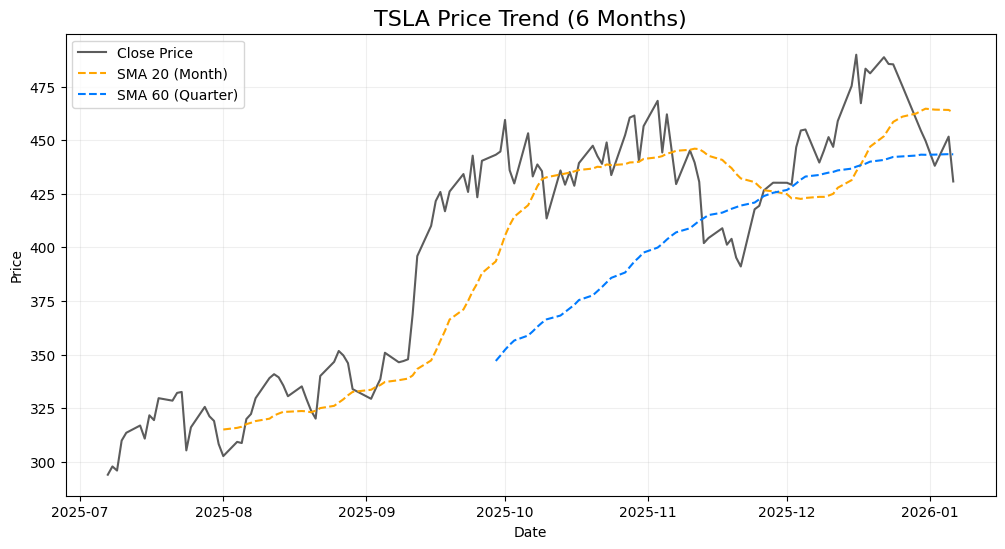

✅ 圖表繪製完成！


In [ ]:
# @title 6. 啟動分析 (Run the System)

from IPython.display import display, Markdown, HTML, Image
import textwrap
import matplotlib.pyplot as plt
import yfinance as yf
import re

# ==========================================
# 1. 設定參數
# ==========================================
ticker_input = "TSLA" # @param ["NVDA", "TSLA", "PLTR", "MSTR", "INTC", "AAPL", "TSM", "COIN", "BA", "2330.TW"] {allow-input: true}

print(f"=== 🚀 開始啟動 Dialectic Flow 2.0: {ticker_input} ===\n")
inputs = {"ticker": ticker_input, "revision_count": 0}

print("--- 思考過程 (Thinking Process) ---")

# 初始化 final_state
final_state = inputs.copy()

# ==========================================
# 2. 執行過程 (串流)
# ==========================================
for output in app.stream(inputs):
    for key, value in output.items():
        if not value: continue

        # 更新狀態
        final_state.update(value)
        print(f"📍 執行節點: {key}")

        # 顯示即時進度
        if "bull_score" and "bear_score" in value:
            pass_threshold = getattr(SystemConfig, 'PASS_THRESHOLD', 85)
            max_revisions = getattr(SystemConfig, 'MAX_REVISIONS', 3)
            current_rev = value.get('revision_count', 0)

            print(f"   📊 評分 - Bull: {value['bull_score']} | Bear: {value['bear_score']}")

            # 情況 A: 高分通過
            if value['bull_score'] >= pass_threshold and value['bear_score'] >= pass_threshold:
                print(f"   ✅ 結果: 雙方皆達高標 ({pass_threshold}+)，準備生成懶人包...\n")

            # 情況 B: 分數不夠，但次數已滿
            elif current_rev > max_revisions:
                print(f"   🛑 結果: 未達標，但校閱次數已滿 ({current_rev}) -> 強制進入說書人環節\n")

            # 情況 C: 分數不夠，還有機會
            else:
                print(f"   ↩️ 結果: 未達標，要求重寫 (剩餘機會: {1 + max_revisions - current_rev})...\n")

        elif "story_content" in value:
            print("   🎭 說書人正在排版 IG 貼文...")

        elif "market_data" in value:
            print("   🖨️ 資料收集完成\n")

print("\n" + "="*30)
print("🎉 分析完成！您的財經懶人包已送達 📬")
print("="*30 + "\n")

# ==========================================
# 3. 視覺化渲染 (UI Rendering)
# ==========================================

def display_final_result(state):
    ticker = state.get('ticker', 'STOCK')
    market_data = str(state.get('market_data', ''))

    # --- [A] 抓取網域 (Domain Extraction) ---
    domain = f"{ticker.split('.')[0].lower()}.com" # 預設猜測

    try:
        # 尋找 http://xxx.com 或 https://xxx.com
        url_match = re.search(r'https?://(www\.)?([a-zA-Z0-9-]+\.[a-zA-Z]+)', market_data)
        if url_match:
            domain = url_match.group(2) # 抓取 domain 部分 (e.g., tsmc.com)
    except:
        pass

    # --- [B] 圖片來源 ---
    img_src = f"https://www.google.com/s2/favicons?domain={domain}&sz=128"

    # 備用文字圖
    img_fallback = f"https://via.placeholder.com/80/007bff/ffffff?text={ticker}"

    # --- [C] HTML 渲染 ---
    html_header = f"""
    <div style="
        background: linear-gradient(135deg, #fdfbfb 0%, #ebedee 100%);
        padding: 20px;
        border-radius: 15px;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        display: flex;
        align-items: center;
        margin-bottom: 20px;
        font-family: 'Helvetica Neue', Arial, sans-serif;
    ">
        <div style="
            background: white;
            padding: 10px;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            margin-right: 20px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            width: 80px;
            height: 80px;
            overflow: hidden;
        ">
            <img src="{img_src}"
                 onerror="this.src='{img_fallback}'"
                 alt="{ticker} Logo"
                 style="width: 100%; height: 100%; object-fit: contain;">
        </div>
        <div>
            <h2 style="margin: 0; color: #333; font-size: 24px;">{ticker} 投資生存指南</h2>
            <p style="margin: 5px 0 0 0; color: #666; font-size: 14px;">
                Generated by Dialectic Flow 2.0 • Storyteller Mode 🎭
            </p>
            <p style="margin: 2px 0 0 0; color: #ccc; font-size: 10px;">Source: Google API ({domain})</p>
        </div>
    </div>
    """
    display(HTML(html_header))

    # --- [D] 顯示內容 ---
    story = state.get('story_content', '⚠️ 內容生成失敗')
    display(Markdown(story))

    # --- [E] 顯示折疊區塊 ---
    deep_dive_html = f"""
    <br>
    <details style="background-color: #fff; border: 1px solid #e0e0e0; padding: 15px; border-radius: 10px; margin-top: 20px;">
        <summary style="cursor: pointer; font-weight: bold; color: #007bff; font-size: 16px;">
            🕵️‍♂️ [進階] 點擊查看：分析師深度辯論紀錄 (原始報告)
        </summary>
        <div style="padding-top: 15px;">
            <div style="margin-bottom: 20px;">
                <h3 style="color: #28a745;">🐂 Bull Report (Score: {state.get('bull_score')})</h3>
                <div style="background-color: #f0fff4; border-left: 4px solid #28a745; padding: 10px 15px; color: #2c3e50; font-size: 14px;">
                    {state.get('bull_report', '').replace(chr(10), '<br>')}
                </div>
                <p style="font-size: 12px; color: #666;">Feedback: {state.get('bull_feedback')}</p>
            </div>
            <div style="margin-bottom: 20px;">
                <h3 style="color: #dc3545;">🐻 Bear Report (Score: {state.get('bear_score')})</h3>
                <div style="background-color: #fff5f5; border-left: 4px solid #dc3545; padding: 10px 15px; color: #2c3e50; font-size: 14px;">
                    {state.get('bear_report', '').replace(chr(10), '<br>')}
                </div>
                <p style="font-size: 12px; color: #666;">Feedback: {state.get('bear_feedback')}</p>
            </div>
            <hr style="border-top: 1px dashed #bbb;">
            <p><b>🏆 Manager Final Decision:</b> {state.get('final_decision')}</p>
        </div>
    </details>
    """
    display(HTML(deep_dive_html))

display_final_result(final_state)

# ==========================================
# 📊 技術線圖
# ==========================================
def plot_stock_chart(ticker):
    print(f"\n📈 正在繪製 {ticker} 的技術線圖...")
    try:
        df = yf.Ticker(ticker).history(period="6mo")
        if df.empty:
            print("❌ 無法獲取繪圖數據")
            return

        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_60'] = df['Close'].rolling(window=60).mean()

        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'], label='Close Price', color='#333', alpha=0.8, linewidth=1.5)
        plt.plot(df.index, df['SMA_20'], label='SMA 20 (Month)', color='#ffa500', linestyle='--')
        plt.plot(df.index, df['SMA_60'], label='SMA 60 (Quarter)', color='#007bff', linestyle='--')

        plt.title(f"{ticker} Price Trend (6 Months)", fontsize=16)
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True, alpha=0.2)
        plt.show()
        print("✅ 圖表繪製完成！")
    except Exception as e:
        print(f"❌ 繪圖發生錯誤: {e}")

plot_stock_chart(ticker_input)

### 🎯 測試代號參考 (Reference Tickers)
為了測試 **Dialectic Flow** 的多空辯證能力，建議選擇具有**高爭議性**或**趨勢明顯**的標的：

| 代號 | 公司名稱 | 🐂 多頭看點 (Bull Argument) | 🐻 空頭看點 (Bear Argument) |
| :--- | :--- | :--- | :--- |
| **NVDA** | NVIDIA | AI 晶片壟斷、營收暴增、毛利驚人 | 估值過高、競爭加劇 (AMD/Intel)、週期性風險 |
| **TSLA** | Tesla | Robotaxi 自駕、Optimus 機器人、能源業務 | 電動車需求放緩、中國車企殺價競爭、利潤率下滑 |
| **PLTR** | Palantir | AIP 平台需求強勁、國防合約護城河 | 本益比極高 (昂貴)、內部人拋售、營收成長能否持續 |
| **MSTR** | MicroStrategy | 比特幣槓桿代理人、加密貨幣牛市紅利 | 缺乏實體業務支撐、比特幣崩盤風險、溢價過高 |
| **INTC** | Intel | 晶圓代工轉型、美國製造補貼、股價跌深 (Deep Value) | 製程落後台積電、鉅額虧損、裁員風暴、被剔除道瓊 |
| **AAPL** | Apple | iPhone 換機潮 (Apple Intelligence)、服務營收 | 創新停滯、中國市場市佔流失、歐盟監管罰款 |
| **TSM** | 台積電 (ADR) | 先進製程壟斷、AI 晶片唯一軍火商 | 地緣政治風險 (China Risk)、美國設廠成本高昂 |
| **COIN** | Coinbase | 加密貨幣交易熱潮、ETF 託管龍頭 | SEC 監管訴訟、手續費競爭、加密寒冬風險 |
| **BA** | Boeing | 訂單積壓龐大、全球航空雙寡頭 | 安全事故頻傳、罷工影響、供應鏈斷鏈 |

> 💡 **小提示：** 台股代號請加上後綴 (如 `2330.TW`, `2603.TW`)，但建議優先使用美股代號 (如 `TSM`)，Llama 3 對英文財報的解析能力通常更強。